In [93]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Load in all the Data

In [94]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_PREDS_INPUT_PATH = file_paths.get("smoke_impact_model_predictions.csv")
NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")
EI_MODEL_INPUT_PATH = file_paths.get("ei_model_output")

EI_PREDS_OUTPUT_PATH = file_paths.get("economic_impact_model_predictions.csv")

In [95]:
# Load dataset
si_preds_df = pd.read_csv(SI_PREDS_INPUT_PATH)

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

## Review the Data

In [96]:
print(si_preds_df.head(5))

print(si_preds_df.columns)

   year  predicted_normalized_total_acres_burned  \
0  2021                                 0.483929   
1  2022                                 0.483929   
2  2023                                 0.483929   
3  2024                                 0.483929   
4  2025                                 0.483929   

   predicted_normalized_avg_distance  total_acres_burned_weighted  \
0                           0.552325                     0.483929   
1                           0.552325                     0.483929   
2                           0.552325                     0.483929   
3                           0.552325                     0.483929   
4                           0.552325                     0.483929   

   distance_weighted  predicted_smoke_impact  
0           0.552325               34.902199  
1           0.552325               34.902199  
2           0.552325               34.902199  
3           0.552325               34.902199  
4           0.552325               34

In [97]:
print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              34.1                   609366.0   
1  2009-10-01  2009-10-01              34.1                   610121.0   
2  2010-05-01  2010-05-01              35.3                   634087.0   
3  2010-06-01  2010-06-01              35.5                   645307.0   
4  2010-07-01  2010-07-01              35.4                   648544.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                             10.2                 35.1   
1                             10.1                 34.9   
2                              9.4                 33.8   
3                             10.0                 34.3   
4                              9.8                 34.3   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      622233.0                                 7.1   
1                      625384.0                           

## Predict Values for NOAA and BLS Features using 5 year rolling averages

In [98]:
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])

In [99]:
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year
fire_season_data = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

In [100]:
group_columns = ['year','noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
fire_season_data = fire_season_data[group_columns]

# %% [Group by Year and Calculate Annual Averages for May–October]
annual_avg = fire_season_data.groupby('year').mean().reset_index()

In [101]:
print(annual_avg)

    year  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0   2009  68.200000   9.575000             -2.570633   
1   2010  79.266667   3.396667              3.607917   
2   2011  76.633333   3.425000             -0.047076   
3   2012  76.883333   3.355000             -1.341578   
4   2013  75.633333   4.688333             -0.039942   
5   2014  75.516667   5.141667              1.056529   
6   2015  77.116667   3.920000              0.331041   
7   2016  79.066667   3.613333              1.191054   
8   2017  75.350000   4.615000              1.024088   
9   2018  77.783333   3.551667             -0.177968   
10  2019  77.083333   6.630000             -0.736916   
11  2020  75.050000   3.300000              1.174386   
12  2021  76.133333   3.950000             -1.790849   
13  2022  78.083333   3.696667             -1.113019   
14  2023  76.933333   3.683333             -1.032851   
15  2024  78.960000   5.326000             -1.656681   

    bls_pct_diff_laus_labor_force  
0          

In [102]:
# %% [Prepare Future Predictions]
# Generate rows for future years
future_years = range(2025, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

# Create a copy of the annual averages to dynamically update rolling averages
dynamic_annual_avg = annual_avg.copy()

# Use dynamic rolling averages to predict future values
for i, row in future_predictions.iterrows():
    # Calculate rolling averages from the most recent 3 years
    rolling_tavg = dynamic_annual_avg['noaa_tavg'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_prcp = dynamic_annual_avg['noaa_prcp'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_sae_hrs = dynamic_annual_avg['bls_pct_diff_sae_hrs'].rolling(window=5, min_periods=1).mean().iloc[-1]
    rolling_labor_force = dynamic_annual_avg['bls_pct_diff_laus_labor_force'].rolling(window=5, min_periods=1).mean().iloc[-1]

    # Assign the calculated rolling averages as predictions for the future year
    future_predictions.loc[i, 'predicted_tavg'] = rolling_tavg
    future_predictions.loc[i, 'predicted_prcp'] = rolling_prcp
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = rolling_sae_hrs
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = rolling_labor_force

    # Append the predicted values to the dynamic dataset
    new_row = {
        'year': row['year'],
        'noaa_tavg': rolling_tavg,
        'noaa_prcp': rolling_prcp,
        'bls_pct_diff_sae_hrs': rolling_sae_hrs,
        'bls_pct_diff_laus_labor_force': rolling_labor_force
    }
    dynamic_annual_avg = pd.concat([dynamic_annual_avg, pd.DataFrame([new_row])], ignore_index=True)

# %% [Merge with Smoke Impact Predictions]
# Merge with smoke impact predictions on the year
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')

# Rename columns to align with the economic impact model expectations
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)



## Economic Impact Model Predictions

In [103]:
# Load the trained Gradient Boosting model
with open(EI_MODEL_INPUT_PATH , 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

In [104]:
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

# Extract features for prediction
X_future = future_predictions[prediction_features]

# %% [Make Predictions]
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)



In [105]:
print(future_predictions.columns)

Index(['year', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs',
       'bls_pct_diff_laus_labor_force', 'scaled_avg_daily_smoke_impact',
       'pct_diff_laus_unemployment_rate'],
      dtype='object')


In [106]:
print(future_predictions)

    year  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0   2025  77.032000   3.991200             -0.883803   
1   2026  77.428400   4.129440             -1.295441   
2   2027  77.687413   4.165328             -1.196359   
3   2028  77.608229   4.259060             -1.213027   
4   2029  77.743209   4.374206             -1.249062   
5   2030  77.499850   4.183847             -1.167538   
6   2031  77.593420   4.222376             -1.224285   
7   2032  77.626424   4.240963             -1.210054   
8   2033  77.614227   4.256090             -1.212793   
9   2034  77.615426   4.255496             -1.212747   
10  2035  77.589869   4.231755             -1.205484   
11  2036  77.607873   4.241336             -1.213073   
12  2037  77.610764   4.245128             -1.210830   
13  2038  77.607632   4.245961             -1.210985   
14  2039  77.606313   4.243935             -1.210624   
15  2040  77.604490   4.241623             -1.210199   
16  2041  77.607414   4.243597             -1.21

# Charts for Predictions

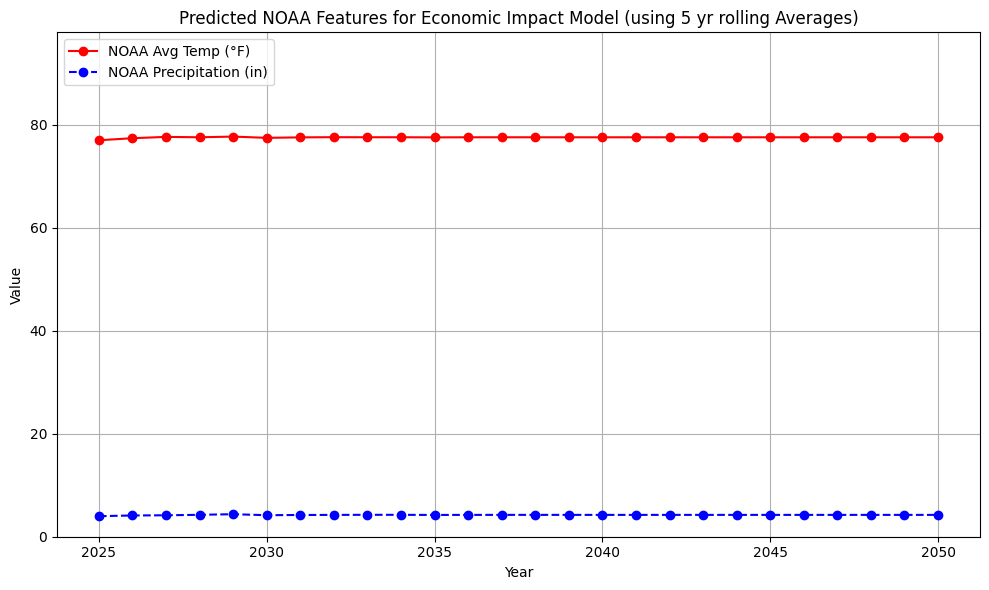

In [107]:
# %% [Plot NOAA Data]
plt.figure(figsize=(10, 6))

# Plot temperature (noaa_tavg)
plt.plot(future_predictions['year'], future_predictions['noaa_tavg'], 
         marker='o', linestyle='-', color='r', label='NOAA Avg Temp (°F)')

# Plot precipitation (noaa_prcp)
plt.plot(future_predictions['year'], future_predictions['noaa_prcp'], 
         marker='o', linestyle='--', color='b', label='NOAA Precipitation (in)')

# Add labels, title, legend, and grid
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Predicted NOAA Features for Economic Impact Model (using 5 yr rolling Averages)')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0, 98)

# Show the chart
plt.tight_layout()
plt.show()

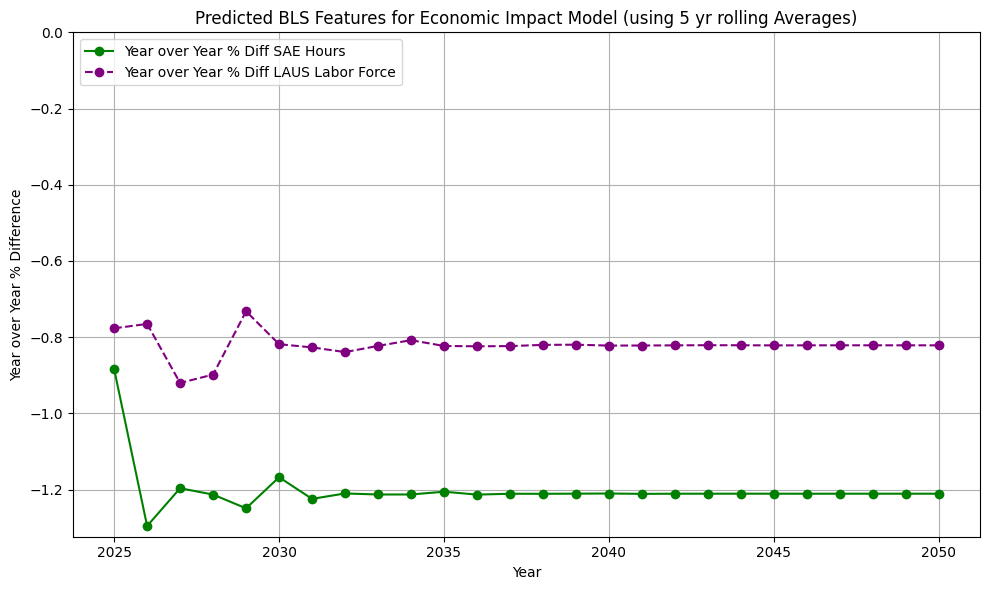

In [108]:
# %% [Plot BLS Data]
plt.figure(figsize=(10, 6))

# Plot BLS metrics
plt.plot(future_predictions['year'], future_predictions['bls_pct_diff_sae_hrs'], 
         marker='o', linestyle='-', color='g', label='Year over Year % Diff SAE Hours')
plt.plot(future_predictions['year'], future_predictions['bls_pct_diff_laus_labor_force'], 
         marker='o', linestyle='--', color='purple', label='Year over Year % Diff LAUS Labor Force')

# Add labels, title, legend, and grid
plt.xlabel('Year')
plt.ylabel('Year over Year % Difference')
plt.title('Predicted BLS Features for Economic Impact Model (using 5 yr rolling Averages)')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(None, 0)

# Show the chart
plt.tight_layout()
plt.show()

In [109]:
# %% [Save Predictions]
future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")

Predictions saved to final-output/economic_impact_estimate_mdl_future_prediction.csv


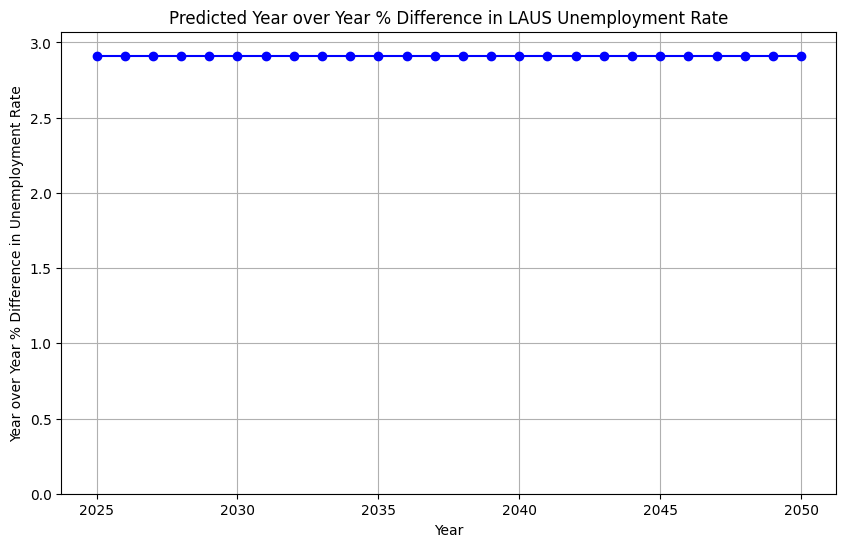

In [110]:
# %% [Plot Predictions]
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Year over Year % Difference in Unemployment Rate')
plt.title('Predicted Year over Year % Difference in LAUS Unemployment Rate')
plt.ylim(0, None)
plt.grid(True)
plt.show()